In [44]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u'(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|)$$

the proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [30]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [45]:
"""
Generating the data function
"""
f_data = data[:,300,300]
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='quadratic')

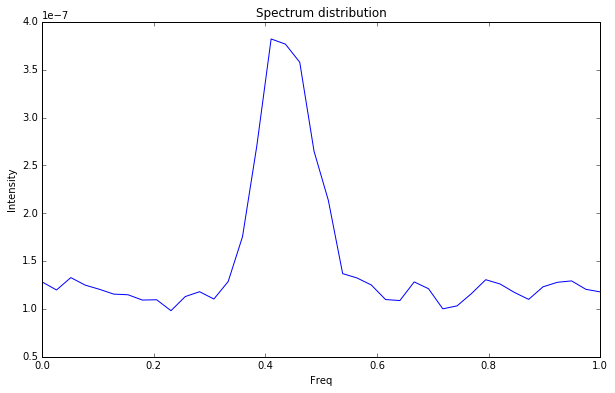

In [51]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, '-')
plt.title('Spectrum distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [26]:
#setting parameters
a = 0.1
b = 1.
N = 50

z = sym.Symbol('z')

#Penalizing function and its derivatives
psi1 = sym.exp(z)
d1psi1 = sym.diff(psi1, z)
d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')

#Smoothing function and its derivatives
lamb = 0.5
psi2 = 2*lamb*sym.log(1 + z**2/lamb)
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [37]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    return retval

In [38]:
""" Computing collocation points """
xc = np.linspace(0., 1., N+1)[1::]-(1./(2.*N))

""" Computing evaluation points """
xe = np.linspace(0., 1., 2*N, endpoint=True)

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation point will be the same
"""
Dx = np.empty((2*N,N))
for k in range(2*N):
	Dx[k,:] = (xe[k] - xc)

In [39]:
def F(X):
    #unpacking parameters
    N = len(X)/2
    c = X[0:N]
    sig = X[N:]
    
    #phi function's evaluation
    phi_m   = phi(Dx, sig)
    phix_m  = phix(Dx, sig)
    phixx_m = phixx(Dx, sig)
    
    #computing the Euler-Lagrange equation
    u   = np.dot(phi_m, c)
    ux  = np.dot(phix_m, c)
    uxx = np.dot(phixx_m, c)
    return 2*(u-f0) + a*d1psi1(u-f0) - b*uxx*d2psi2(np.abs(ux))


In [40]:
c0 = 0.1*np.ones(50)
sig0 = 0.01*np.ones(50)
X = np.concatenate([c0,sig0])

In [42]:
F(X)

array([   4.41938587, -134.07844785, -179.10264806,  718.75790459,
       -684.57947978,  669.3554632 , -653.06678673,  631.92138175,
       -611.27794236,  586.16891945, -562.16401145,  534.77794582,
       -508.45245882,  480.39164523, -452.75257552,  425.3817107 ,
       -397.35173964,  371.69894594, -344.09496824,  320.81095834,
       -294.34107114,  273.71024688, -248.97768159,  230.97305709,
       -208.47295172,  192.84260148, -172.94755449,  159.31700239,
       -142.25463992,  130.22443116, -116.05989298,  105.28225414,
        -93.91259079,   84.13908862,  -75.30378972,   66.4047759 ,
        -59.70962319,   51.6683621 ,  -46.62253568,   39.50875937,
        -35.5708139 ,   29.49902909,  -26.1290377 ,   21.20924193,
        -17.9192058 ,   14.20790518,  -10.60556852,    8.06482341,
         -3.88347681,    2.35353202,    2.53437743,   -3.34479695,
          8.93487217,   -9.43763931,   15.62183605,  -16.31624477,
         22.93335219,  -24.35406516,   31.2527285 ,  -33.91013

In [128]:
sp.optimize.fsolve(F, X)

/home/martin/miniconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([  1.17363597e-01,   1.16546268e-01,   1.06343164e-01,
         7.16619866e-02,   2.99204715e-02,   1.91765109e-02,
        -1.30656719e-01,  -1.68404415e-01,  -8.58842567e-02,
         2.56940070e-01,  -3.66855802e-01,   8.44300278e-03,
         4.53069823e-02,   6.21377252e-02,   8.40699533e-02,
         1.00617170e-01,   1.20085442e-01,   1.27779710e-01,
         1.35570925e-01,   1.34201496e-01,   1.39378670e-01,
         1.39708529e-01,   1.41633669e-01,   1.40019635e-01,
         1.41411964e-01,   1.37527848e-01,   1.40195273e-01,
         1.38796008e-01,   1.40279449e-01,   1.37644006e-01,
         1.35599106e-01,   1.34996006e-01,   1.30884236e-01,
         1.23470533e-01,   1.07304572e-01,   8.53071999e-02,
         6.38679813e-02,   3.17774808e-02,  -1.76181033e-03,
        -2.91623979e-02,  -2.29118400e-01,   1.14425876e-01,
        -8.54041608e-02,  -1.20540006e-01,  -8.56673839e-05,
         3.88223842e-02,   7.59027102e-02,   1.03843307e-01,
         1.20869821e-01,